In [1]:
import ast
import numpy as np
import pandas as pd
import pickle
import string
import mglearn
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
PATHS = {
    "dataset": "data.csv",
    "feature-columns": "feature-columns.pkl",
    "image-labels": "image-labels.pkl",
    "scaler": "classifiers/scaler.pkl",
    "pca": "classifiers/pca.pkl",
    "classifier": "classifiers/rcnn-mlp.h5",
}

In [3]:
dataset = pd.read_csv(PATHS["dataset"], index_col=False)
pos = dataset[dataset["brand"].astype(int) == 1]
neg = dataset[dataset["brand"].astype(int) == 0]

In [4]:
class Features:
    
    def compute_features(self, sample):
        feature_columns = pickle.load(open(PATHS["feature-columns"], "rb"))
        features = pd.DataFrame(columns=feature_columns)
        features["Has_Biography"] = self._fe_has_biography(sample)
        features["Media_Count"] = sample["mediaCount"].fillna(-1)
        features["Has_City_Id"] = self._fe_has_city_id(sample)
        features["Latitude"] = sample["latitude"].fillna(-1)
        features["Longitude"] = sample["longitude"].fillna(-1)
        features["Has_Zip"] = self._fe_has_zip(sample)
        features["Has_Contact_Phone_Number"] = self._fe_has_contact_phone_number(sample)
        features["Following_Count"] = sample["followingCount"].fillna(-1)
        features["Follower_Count"] = sample["followerCount"].fillna(-1)
        features["Usertags_Count"] = sample["usertagsCount"].fillna(-1)
        features["Is_External_Url"] = self._fe_is_external_url(sample)
        features["Is_Business"] = sample["isBusiness"].fillna(-1).astype(int)
        category_features = self._fe_category(sample)
        for category_column in category_features.columns:
            if category_column in feature_columns:
                features[category_column] = category_features[category_column]
        features["Geo_Media_Count"] = sample["geoMediaCount"].fillna(-1)
        features["Shoppable_Posts_Count"] = sample["shoppablePostsCount"].fillna(-1)
        features["Following_Tag_Count"] = sample["followingTagCount"].fillna(-1)
        features["Is_Picture"] = self._fe_is_picture(sample)
        image_label_features = self._fe_image_labels(sample)
        for image_label_column in image_label_features.columns:
            if image_label_column in feature_columns:
                features[image_label_column] = image_label_features[image_label_column]
        features["Has_Email"] = sample["hasEmail"].astype(int)
        return features

    @staticmethod
    def _fe_has_biography(sample):
        feature = []
        for item in sample["biography"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_has_city_id(sample):
        feature = []
        for item in sample["cityId"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature
    
    @staticmethod
    def _fe_has_zip(sample):
        feature = []
        for item in sample["zip"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_has_contact_phone_number(sample):
        feature = []
        for item in sample["contactPhoneNumber"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_is_external_url(sample):
        feature = []
        for item in sample["externalUrl"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_category(sample):
        return pd.get_dummies(sample["category"])

    @staticmethod
    def _fe_is_picture(sample):
        feature = []
        for item in sample["picture"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_image_labels(sample):
        image_labels = pickle.load(open(PATHS["image-labels"], "rb"))
        image_labels_df = pd.DataFrame(columns=image_labels)
        for item in sample["imageLabels"]:
            image_labels_df.loc[len(image_labels_df)] = 0
            if "nan" not in item:
                labels = ast.literal_eval(item[1:][:-1])
                if "((" in str(labels):
                    for label in labels:
                        val = image_labels_df.loc[image_labels_df.index[-1], label[0]]
                        image_labels_df.loc[image_labels_df.index[-1], label[0]] = max(label[1], val)
                else:
                    label = labels
                    image_labels_df.loc[image_labels_df.index[-1], label[0]] = label[1]
            else:
                image_labels_df.loc[image_labels_df.index[-1], "nan"] = 1
        return image_labels_df

    '''Tokenization'''
    @staticmethod
    def tokenize(sample, column, max_len=100):
        alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
        vocab = {}
        for i, c in enumerate(alphabet):
            vocab[c] = i + 1
        items = sample[column].astype(str).str.encode("utf-8").str.decode("ascii", "ignore").values.tolist()
        tokenized = np.zeros((len(items), max_len))
        for i in range(len(items)):
            item_arr = np.zeros(max_len)
            chars = list(items[i].lower())
            for j in range(len(chars)):
                # counter should not larger than max_len
                if j >= max_len:
                    break
                if chars[j] in alphabet:
                    item_arr[j] = vocab[chars[j]]
                else:
                    item_arr[j] = max(vocab.values())
            tokenized[i, :] = item_arr
        return tokenized

    @staticmethod
    def untokenize(tokenized):
        alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
        reverse_vocab = {}
        for i, c in enumerate(alphabet):
            reverse_vocab[i + 1] = c
        items = []
        for item_arr in tokenized:
            item = " ".join([reverse_vocab[i] if i > 0 else "" for i in item_arr])
            items.append(item)
        return items

In [5]:
f = Features()
features = f.compute_features(dataset)
tokenized_biography = f.tokenize(dataset, "biography", 170)
untokenized_biography = f.untokenize(tokenized_biography)
labels = dataset["brand"].astype(int)

In [6]:
scaler = pickle.load(open(PATHS["scaler"], "rb"))
scaled_features = scaler.transform(features)

In [7]:
pca = pickle.load(open(PATHS["pca"], "rb"))
pca_features = pd.DataFrame(data=pca.transform(scaled_features), columns=["PC" + str(i + 1) for i in range(30)])

In [8]:
alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
vocab_size = len(alphabet)
vocab_size

70

In [9]:
embedding_weights = [] # (71, 70)
# Zero vector to represent the PAD
embedding_weights.append(np.zeros(vocab_size))
for i, c in enumerate(alphabet):
    one_hot = np.zeros(vocab_size)
    one_hot[i] = 1
    embedding_weights.append(one_hot)
embedding_weights = np.array(embedding_weights)
# First row all 0 for PAD, 69 char, last row for UNK
print(embedding_weights.shape)
embedding_weights

(71, 70)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
input_size = 170
embedding_size = 70
conv_layers = [[8, 4, 2], [8, 4, 2], [8, 4, 2]]
full_connected_layers = [8, 8]
mlp_layers = [64, 256, 128, 64]
dropout = 0.2

In [11]:
embedding_layer = Embedding(
    input_dim=vocab_size + 1,
    output_dim=embedding_size,
    input_length=input_size,
    weights=[embedding_weights])

In [12]:
rcnn_inputs = Input(shape=(input_size,), dtype="int64")
x = embedding_layer(rcnn_inputs)
x = Bidirectional(LSTM(16, recurrent_dropout=dropout, return_sequences=True))(x)
print("LSTM {}".format(x.shape))
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    print("Conv1D {}".format(x.shape))
    x = Activation("relu")(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        print("MaxPooling1D {}".format(x.shape))
x = Flatten()(x)
print("Flatten {}".format(x.shape))
for dense_size in full_connected_layers:
    x = Dense(dense_size, activation="relu")(x)
    print("Dense {}".format(x.shape))
    x = Dropout(dropout)(x)
rcnn_outputs = x

2023-03-04 10:52:44.600537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LSTM (None, 170, 32)
Conv1D (None, 167, 8)
MaxPooling1D (None, 83, 8)
Conv1D (None, 80, 8)
MaxPooling1D (None, 40, 8)
Conv1D (None, 37, 8)
MaxPooling1D (None, 18, 8)
Flatten (None, 144)
Dense (None, 8)
Dense (None, 8)


In [13]:
mlp_inputs = Input(shape=(pca_features.shape[1],), name="mlp_input")
y = mlp_inputs
for dense_size in mlp_layers:
    y = Dense(dense_size, activation="relu")(y)
    print("Dense {}".format(y.shape))
    y = Dropout(dropout)(y)
mlp_outputs = y

Dense (None, 64)
Dense (None, 256)
Dense (None, 128)
Dense (None, 64)


In [14]:
concatenated = concatenate([rcnn_outputs, mlp_outputs])
outputs = Dense(1, activation="sigmoid")(concatenated)

In [15]:
classifier = Model([rcnn_inputs, mlp_inputs], outputs)

In [16]:
classifier.load_weights(PATHS["classifier"])

32/32 [==============================] - 2s 28ms/step
Precision: 0.852
Recall: 0.833
Threshold: 0.502


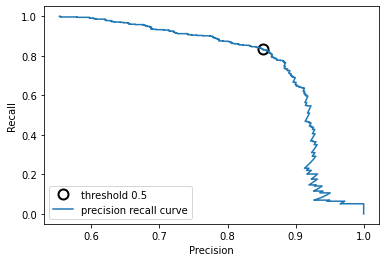

In [17]:
precision, recall, thresholds = precision_recall_curve(
    labels, np.asarray(classifier.predict([tokenized_biography, pca_features])).reshape(-1))
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_zero], recall[close_zero], "o", markersize=10, label="threshold 0.5", fillstyle="none",
        c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
print("Precision: {:.3f}\nRecall: {:.3f}\nThreshold: {:.3f}".format(precision[close_zero],
                                                                    recall[close_zero], thresholds[close_zero]))

32/32 [==============================] - 1s 28ms/step
TPR: 0.831
FPR: 0.174
Threshold: 0.503


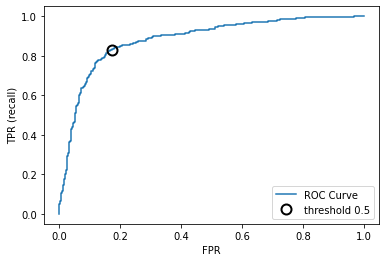

In [18]:
fpr, tpr, thresholds = roc_curve(labels, np.asarray(
    classifier.predict([tokenized_biography, pca_features])).reshape(-1))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_zero], tpr[close_zero], "o", markersize=10, label="threshold 0.5", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)
print("TPR: {:.3f}\nFPR: {:.3f}\nThreshold: {:.3f}".format(tpr[close_zero], fpr[close_zero], thresholds[close_zero]))

In [19]:
predictions = np.asarray(classifier.predict([tokenized_biography, pca_features])).reshape(-1) > 0.5
print(classification_report(labels, predictions, target_names=['Not Brand', 'Brand']))

32/32 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

   Not Brand       0.80      0.83      0.82       454
       Brand       0.85      0.83      0.84       545

    accuracy                           0.83       999
   macro avg       0.83      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999



Confusion matrix:
[[375  79]
 [ 91 454]]


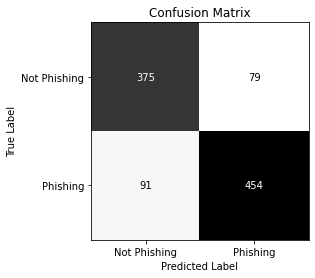

In [20]:
confusion = confusion_matrix(labels, predictions)
print("Confusion matrix:\n{}".format(confusion))
scores_image = mglearn.tools.heatmap(
        confusion_matrix(labels, predictions), xlabel="Predicted Label", ylabel="True Label",
        xticklabels=["Not Phishing", "Phishing"],
        yticklabels=["Not Phishing", "Phishing"],
        cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion Matrix")
plt.gca().invert_yaxis()